<a href="https://colab.research.google.com/github/Buuuuli/AIPI540_individual/blob/main/try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#PROJ ="MyDrive/repos"
#PROJECT_PATH = join(ROOT, PROJ)
#!mkdir "PROJECT_PATH"

In [2]:
!ls

drive  local-file.xlsx	sample_data


In [3]:
%cd /content/drive/"My Drive"/AIPI540

/content/drive/My Drive/AIPI540


In [10]:
import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary
import cv2 as cv
import glob
from PIL import Image
import pickle as pkl
from tqdm import tqdm
from zipfile import ZipFile



from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# check what types of image we get
#set the image directory
files = os.listdir("./image/")
# print the types of image
print(set([x.split(".")[1] for x in files]))


{'jpg'}


In [6]:
# prepare the directory for each image type
extensions = ("*.jpg")
path = []
for extension in extensions:
    path.extend(glob.glob("./image/"+extension))

In [7]:
# set the transforms
trans = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
# read data
cv_img = []
for img in tqdm(path):
    # read image > to Tensor > permute the data > resize > flatten
    try:
      n = trans(cv.imread(img))
    except:
      print(img)
      pass
    cv_img.append(n)

100%|██████████| 10016/10016 [02:32<00:00, 65.59it/s]

./image/.


In [37]:
url1 = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/raw_metadata.csv?raw=true'
df = pd.read_csv(url1,index_col=0)
print(df.head(5))

                 image_id   dx    dx_type   age     sex     localization
lesion_id                                                               
HAM_0000550  ISIC_0024306   nv  follow_up  45.0    male            trunk
HAM_0003577  ISIC_0024307   nv  follow_up  50.0    male  lower extremity
HAM_0001477  ISIC_0024308   nv  follow_up  55.0  female            trunk
HAM_0000484  ISIC_0024309   nv  follow_up  40.0    male            trunk
HAM_0003350  ISIC_0024310  mel      histo  60.0    male            chest


In [38]:
# group age
bins =[0,10,20,30,40,50,60,70,80,90]
labels = ['children','teenage','young','adult','midage','old1','old2','old3','older']

df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df = df.drop("age", axis=1)

In [39]:
# {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
dx_dict = dict(enumerate(df['dx'].astype('category').cat.categories))

# {0: 'confocal', 1: 'consensus', 2: 'follow_up', 3: 'histo'}
dx_type_dict = dict(enumerate(df['dx_type'].astype('category').cat.categories))

# {0: 'female', 1: 'male', 2: 'unknown'}
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))

# {0: 'abdomen', 1: 'acral', 2: 'back', 3: 'chest', 4: 'ear',
# 5: 'face', 6: 'foot', 7: 'genital', 8: 'hand', 9: 'lower extremity',
# 10: 'neck', 11: 'scalp', 12: 'trunk', 13: 'unknown', 14: 'upper extremity'}
localization_dict = dict(enumerate(df['localization'].astype('category').cat.categories))

# {0: 'children', 1: 'teenage', 2: 'young', 3: 'adult', 4: 'midage',
# 5: 'old', 6: 'old2', 7: 'old3', 8: 'older'}
ageGroup_dict = dict(enumerate(df['ageGroup'].astype('category').cat.categories))

In [40]:
# encode 'dx','dx_type','sex', 'localization'
for col in ['dx','dx_type','sex','localization','ageGroup']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

In [42]:
len(cv_img)

10016

In [43]:
len(df)

10015

In [41]:
dict_image = {cv_img[i]: df[col][i] for i in range(len(cv_img))}

IndexError: ignored

In [13]:
train_image, test_image = train_test_split(cv_img, test_size=0.2,shuffle=True ,random_state=45)

In [16]:
batch_size = 16
train_loader_resnet = DataLoader(train_image,batch_size=batch_size, shuffle=False)
test_loader_resnet = DataLoader(test_image,batch_size=batch_size, shuffle=False)

In [17]:
# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [ ]:
#with open('./read_imgs.pkl','wb') as fp:
  #pkl.dump(cv_img,fp)

In [ ]:
#with open('./read_imgs.pkl', 'rb') as fp:
  #imgs = pkl.load(fp)

In [18]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

In [19]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = net.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(10):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [20]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was trained on color (3 input channels)
in_channels = 3
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (7)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 7)

# Train the model
n_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,train_loader_resnet,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
# Test the pre-trained model
acc,recall_vals = test_model(model_resnet,test_loader_resnet,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

In [30]:
x = torch.randn(3, 4)

In [31]:
x

tensor([[ 0.0582, -0.1821, -1.9462,  1.0853],
        [-0.0085, -0.2652,  0.7063,  1.0526],
        [-1.4475,  0.0270, -0.4036,  0.0922]])

In [32]:
x = torch.unsqueeze(x, dim=0)

In [35]:
x.shape

torch.Size([1, 3, 4])

torch.Size([3, 450, 600])

In [ ]:
url1 = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/raw_metadata.csv?raw=true'

In [ ]:
url = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/tidy_data.csv?raw=true'
df = pd.read_csv(url1,index_col=0)
print(df.head(5))

                 image_id   dx    dx_type   age     sex     localization
lesion_id                                                               
HAM_0000550  ISIC_0024306   nv  follow_up  45.0    male            trunk
HAM_0003577  ISIC_0024307   nv  follow_up  50.0    male  lower extremity
HAM_0001477  ISIC_0024308   nv  follow_up  55.0  female            trunk
HAM_0000484  ISIC_0024309   nv  follow_up  40.0    male            trunk
HAM_0003350  ISIC_0024310  mel      histo  60.0    male            chest


In [ ]:
df.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
#df['dx'] = df['dx'].map({"nv":0,"mel":1,"bkl":2,"bcc":3,"akiec":4,"vasc":5,"df":6})

In [ ]:
# group age
bins =[0,10,20,30,40,50,60,70,80,90]
labels = ['children','teenage','young','adult','midage','old1','old2','old3','older']

df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df = df.drop("age", axis=1)

In [ ]:
# {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
dx_dict = dict(enumerate(df['dx'].astype('category').cat.categories))

# {0: 'confocal', 1: 'consensus', 2: 'follow_up', 3: 'histo'}
dx_type_dict = dict(enumerate(df['dx_type'].astype('category').cat.categories))

# {0: 'female', 1: 'male', 2: 'unknown'}
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))

# {0: 'abdomen', 1: 'acral', 2: 'back', 3: 'chest', 4: 'ear',
# 5: 'face', 6: 'foot', 7: 'genital', 8: 'hand', 9: 'lower extremity',
# 10: 'neck', 11: 'scalp', 12: 'trunk', 13: 'unknown', 14: 'upper extremity'}
localization_dict = dict(enumerate(df['localization'].astype('category').cat.categories))

# {0: 'children', 1: 'teenage', 2: 'young', 3: 'adult', 4: 'midage',
# 5: 'old', 6: 'old2', 7: 'old3', 8: 'older'}
ageGroup_dict = dict(enumerate(df['ageGroup'].astype('category').cat.categories))

In [ ]:
# encode 'dx','dx_type','sex', 'localization'
for col in ['dx','dx_type','sex','localization','ageGroup']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

In [ ]:
df.dx.value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: dx, dtype: int64

In [ ]:
#df['dx_type'] = df['dx_type'].map({"histo":0,"follow_up":1,"consensus":2,"confocal":3})

In [ ]:
#df.sex.value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [ ]:
#df['sex'] = df['sex'].map({"male":0,"female":1,"unknow":2})

In [ ]:
#df.localization.value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [ ]:
#df['localization'] = df['localization'].map({"back":0,"lower extremity":1,"trunk":2,"upper extremity":3,"abdomen":4,"face":5,"chest":6,
                                             "foot":7,"unkown":8,"neck":9,"scalp":10,"hand":11,"ear":12,"genital":13,"acral":14})

In [ ]:
#df.ageGroup.value_counts()

midage      2284
old1        2196
old2        1534
old3        1374
adult       1217
older        694
young        416
children     125
teenage      118
Name: ageGroup, dtype: int64

In [ ]:
#df['ageGroup'] = df['ageGroup'].map({"teenage":0,"children":1,"young":2,"older":3,"adult":4,"old3":5,"old2":6,
                                             "old1":7,"midage":8})

In [ ]:
#df.head()

,image_id,dx,dx_type,sex,localization,ageGroup
lesion_id,,,,,,
HAM_0000550,ISIC_0024306,0,1,0.0,2.0,8
HAM_0003577,ISIC_0024307,0,1,0.0,1.0,7
HAM_0001477,ISIC_0024308,0,1,1.0,2.0,7
HAM_0000484,ISIC_0024309,0,1,0.0,2.0,8
HAM_0003350,ISIC_0024310,1,0,0.0,6.0,6


In [ ]:
X_meta = df[['dx_type','sex','localization','ageGroup']]

In [ ]:
y_meta = df[['dx']]

In [ ]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, test_size=0.2,shuffle=True ,random_state=45)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'min_samples_leaf':[1,3,10],'n_estimators':[100,1000],
          'max_features':[0.1,0.5,1.],'max_samples':[0.5,None],'max_depth':[7]}

model = RandomForestClassifier()
grid_search = GridSearchCV(model,params,cv=3,verbose=10)
grid_search.fit(X_train_meta,y_train_meta)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 1/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.721 total time=   0.3s
[CV 2/3; 1/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 1/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.712 total time=   0.3s
[CV 3/3; 1/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 1/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.714 total time=   0.3s
[CV 1/3; 2/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 2/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.719 total time=   2.7s
[CV 2/3; 2/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 2/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.714 total time=   2.7s
[CV 3/3; 2/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 2/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.716 total time=   2.7s
[CV 1/3; 3/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 3/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.712 total time=   0.3s
[CV 2/3; 3/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 3/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.708 total time=   0.3s
[CV 3/3; 3/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 3/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.713 total time=   0.3s
[CV 1/3; 4/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 4/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.713 total time=   2.6s
[CV 2/3; 4/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 4/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.709 total time=   2.6s
[CV 3/3; 4/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 4/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.712 total time=   2.6s
[CV 1/3; 5/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 5/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.710 total time=   0.3s
[CV 2/3; 5/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 5/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.705 total time=   0.3s
[CV 3/3; 5/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 5/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.708 total time=   0.3s
[CV 1/3; 6/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 6/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.707 total time=   2.6s
[CV 2/3; 6/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 6/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.703 total time=   2.6s
[CV 3/3; 6/36] START max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 6/36] END max_depth=7, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.709 total time=   2.7s
[CV 1/3; 7/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 7/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.720 total time=   0.3s
[CV 2/3; 7/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 7/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.713 total time=   0.3s
[CV 3/3; 7/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 7/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.717 total time=   0.3s
[CV 1/3; 8/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 8/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.717 total time=   2.9s
[CV 2/3; 8/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 8/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.711 total time=   2.9s
[CV 3/3; 8/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 8/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.715 total time=   2.8s
[CV 1/3; 9/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 9/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.716 total time=   0.3s
[CV 2/3; 9/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 9/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.711 total time=   0.3s
[CV 3/3; 9/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 9/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.711 total time=   0.3s
[CV 1/3; 10/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 10/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.711 total time=   2.9s
[CV 2/3; 10/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 10/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.708 total time=   2.8s
[CV 3/3; 10/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 10/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.714 total time=   2.8s
[CV 1/3; 11/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 11/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.711 total time=   0.3s
[CV 2/3; 11/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 11/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.704 total time=   0.3s
[CV 3/3; 11/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 11/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.712 total time=   0.3s
[CV 1/3; 12/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 12/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.713 total time=   2.8s
[CV 2/3; 12/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 12/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.704 total time=   2.8s
[CV 3/3; 12/36] START max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 12/36] END max_depth=7, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.710 total time=   2.8s
[CV 1/3; 13/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 13/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.712 total time=   0.3s
[CV 2/3; 13/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 13/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.713 total time=   0.3s
[CV 3/3; 13/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 13/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.716 total time=   0.3s
[CV 1/3; 14/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 14/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.721 total time=   2.8s
[CV 2/3; 14/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 14/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.709 total time=   2.8s
[CV 3/3; 14/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 14/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.716 total time=   2.7s
[CV 1/3; 15/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 15/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.720 total time=   0.3s
[CV 2/3; 15/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 15/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.714 total time=   0.3s
[CV 3/3; 15/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 15/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.717 total time=   0.3s
[CV 1/3; 16/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 16/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.718 total time=   2.7s
[CV 2/3; 16/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 16/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.710 total time=   2.7s
[CV 3/3; 16/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 16/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.718 total time=   2.8s
[CV 1/3; 17/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 17/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.713 total time=   0.3s
[CV 2/3; 17/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 17/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.708 total time=   0.3s
[CV 3/3; 17/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 17/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.714 total time=   0.3s
[CV 1/3; 18/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 18/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.719 total time=   2.7s
[CV 2/3; 18/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 18/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.708 total time=   2.7s
[CV 3/3; 18/36] START max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 18/36] END max_depth=7, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.713 total time=   2.7s
[CV 1/3; 19/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 19/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.719 total time=   0.3s
[CV 2/3; 19/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 19/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.708 total time=   0.3s
[CV 3/3; 19/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 19/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.718 total time=   0.3s
[CV 1/3; 20/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 20/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.720 total time=   3.1s
[CV 2/3; 20/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 20/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.709 total time=   3.0s
[CV 3/3; 20/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 20/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.718 total time=   3.1s
[CV 1/3; 21/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 21/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.715 total time=   0.3s
[CV 2/3; 21/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 21/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.714 total time=   0.3s
[CV 3/3; 21/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 21/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.715 total time=   0.3s
[CV 1/3; 22/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 22/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.719 total time=   3.0s
[CV 2/3; 22/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 22/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.709 total time=   3.0s
[CV 3/3; 22/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 22/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.718 total time=   3.0s
[CV 1/3; 23/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 23/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.716 total time=   0.3s
[CV 2/3; 23/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 23/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.709 total time=   0.3s
[CV 3/3; 23/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 23/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.716 total time=   0.3s
[CV 1/3; 24/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 24/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.716 total time=   3.0s
[CV 2/3; 24/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 24/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.712 total time=   2.9s
[CV 3/3; 24/36] START max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 24/36] END max_depth=7, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.715 total time=   2.9s
[CV 1/3; 25/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 25/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.723 total time=   0.3s
[CV 2/3; 25/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 25/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.719 total time=   0.3s
[CV 3/3; 25/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 25/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.716 total time=   0.3s
[CV 1/3; 26/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 26/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.725 total time=   2.9s
[CV 2/3; 26/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 26/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.717 total time=   3.0s
[CV 3/3; 26/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 26/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.716 total time=   3.0s
[CV 1/3; 27/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 27/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.721 total time=   0.3s
[CV 2/3; 27/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 27/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.716 total time=   0.3s
[CV 3/3; 27/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 27/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.716 total time=   0.3s
[CV 1/3; 28/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 28/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.722 total time=   3.0s
[CV 2/3; 28/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 28/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.715 total time=   3.1s
[CV 3/3; 28/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 28/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.716 total time=   2.9s
[CV 1/3; 29/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 29/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.721 total time=   0.3s
[CV 2/3; 29/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 29/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.711 total time=   0.3s
[CV 3/3; 29/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 29/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.715 total time=   0.3s
[CV 1/3; 30/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 30/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.720 total time=   3.0s
[CV 2/3; 30/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 30/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.711 total time=   3.1s
[CV 3/3; 30/36] START max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 30/36] END max_depth=7, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.716 total time=   2.9s
[CV 1/3; 31/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 31/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.718 total time=   0.3s
[CV 2/3; 31/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 31/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.717 total time=   0.3s
[CV 3/3; 31/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 31/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.716 total time=   0.3s
[CV 1/3; 32/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 32/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.721 total time=   3.3s
[CV 2/3; 32/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 32/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.718 total time=   3.3s
[CV 3/3; 32/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 32/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.716 total time=   3.3s
[CV 1/3; 33/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 33/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.721 total time=   0.3s
[CV 2/3; 33/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 33/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.717 total time=   0.3s
[CV 3/3; 33/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 33/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.717 total time=   0.3s
[CV 1/3; 34/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 34/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.718 total time=   3.2s
[CV 2/3; 34/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 34/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.717 total time=   3.3s
[CV 3/3; 34/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 34/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.716 total time=   3.3s
[CV 1/3; 35/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 35/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.720 total time=   0.3s
[CV 2/3; 35/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 35/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.716 total time=   0.3s
[CV 3/3; 35/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 35/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.715 total time=   0.3s
[CV 1/3; 36/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 36/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.717 total time=   3.4s
[CV 2/3; 36/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 36/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.717 total time=   3.3s
[CV 3/3; 36/36] START max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 36/36] END max_depth=7, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.718 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7], 'max_features': [0.1, 0.5, 1.0],
                         'max_samples': [0.5, None],
                         'min_samples_leaf': [1, 3, 10],
                         'n_estimators': [100, 1000]},
             verbose=10)

In [ ]:
grid_search.best_params_

{'max_depth': 7,
 'max_features': 1.0,
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [ ]:
# Run the model using the parameters found from the grid search
rf_model_meta = RandomForestClassifier(criterion='gini',max_depth=7, min_samples_leaf=1,n_estimators=100,
                                 max_features=1,max_samples=0.5,random_state=0)
rf_model_meta.fit(X_train_meta, y_train_meta)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=7, max_features=1, max_samples=0.5,
                       random_state=0)

In [ ]:
test_preds = rf_model_meta.predict(X_test_meta).reshape(len(X_test_meta),1)
test_acc = np.sum(test_preds==y_test_meta)/len(y_test_meta)


In [ ]:
test_acc

In [ ]:
def calc_feature_importances(model,feat_names,num_to_show):
    # Determine the relative importance of each feature using the random forest model
    importances = model.feature_importances_
    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()
    return

,Feat Index,Feature,Importance
0,0,dx_type,0.408924
1,3,ageGroup,0.367154
2,2,localization,0.204911
3,1,sex,0.019012


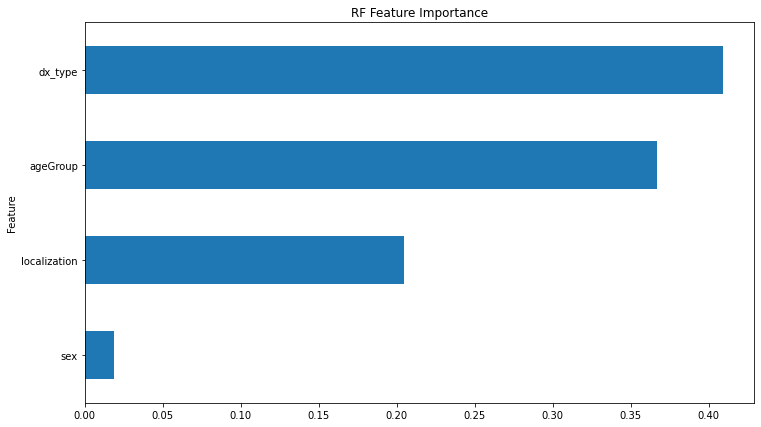

In [ ]:
top_feats = 30
calc_feature_importances(rf_model_meta,X_test_meta.columns,top_feats)